<a href="https://colab.research.google.com/github/Vakhranev/MDB/blob/main/PCA_%D0%B4%D0%BB%D1%8F_Kelly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-22-7bf00dfa1823>:116: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


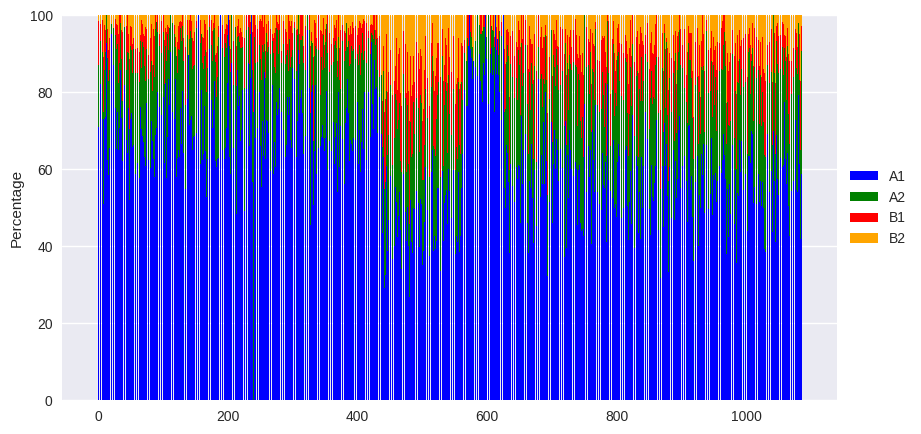

In [22]:
import glob
import os
from pymystem3 import Mystem
import string
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

mystem = Mystem()

students_path = r"/content/Students_texts"
text_contents = {}

x_data = []
level_data = []  # Добавлен список для хранения уровней файлов

for level_folder in glob.glob(students_path + "/*"):
    level = os.path.basename(level_folder)  # Получаем уровень из имени папки
    for text_path in glob.glob(level_folder + "/*.txt"):
        with open(text_path, "r", encoding='utf-8') as file:
            file_name = os.path.basename(text_path)
            text = file.read()
            lemmas = [lemma for lemma in mystem.lemmatize(text)
                      if lemma.strip() and not all(c in string.punctuation or c.isspace() for c in lemma)
                      and not any(c.isalpha() and ord(c) < 128 for c in lemma)]
            lemmas = list(set(lemmas))
            x_data.append(len(lemmas))
            level_data.append(level)  # Добавляем уровень в список
            text_contents[file_name] = lemmas

df = pd.read_csv('ru_m3.csv', sep=';')
df.index = np.arange(1, len(df) + 1)
df = df[['Lemma', 'CEFR']]
mark1 = "a1"
mark2 = "a2"
mark3 = "b1"
mark4 = "b2"
mark5 = "A1"
mark6 = "A2"
mark7 = "B1"
mark8 = "B2"
dc1 = df.query('CEFR == @mark1 | CEFR == @mark5')
dc2 = df.query('CEFR == @mark2 | CEFR == @mark6')
dc3 = df.query('CEFR == @mark3 | CEFR == @mark7')
dc4 = df.query('CEFR == @mark4 | CEFR == @mark8')

slovar1 = dc1['Lemma'].unique()
slovar2 = dc2['Lemma'].unique()
slovar3 = dc3['Lemma'].unique()
slovar4 = dc4['Lemma'].unique()

y_data_1 = []
y_data_2 = []
y_data_3 = []
y_data_4 = []

for file_name, lines in text_contents.items():
    lv1 = 0
    lv2 = 0
    lv3 = 0
    lv4 = 0
    for i in lines:
        if i in slovar1:
            lv1 += 1
        if i in slovar2:
            lv2 += 1
        if i in slovar3:
            lv3 += 1
        if i in slovar4:
            lv4 += 1
    y_data_1.append(lv1)
    y_data_2.append(lv2)
    y_data_3.append(lv3)
    y_data_4.append(lv4)

y_data_5 = []

for i in range(len(y_data_1)):
    diff = x_data[i] - y_data_1[i] - y_data_2[i] - y_data_3[i] - y_data_4[i]
    y_data_5.append(diff)

info = []
info = list(text_contents.keys())
name_to_number = {}

for i, name in enumerate(set(info)):
    name_to_number[name] = i

info_n = [i for i in range(len(info))]

percentages_1 = [y / x * 100 for y, x in zip(y_data_1, x_data)]
percentages_2 = [y / x * 100 for y, x in zip(y_data_2, x_data)]
percentages_3 = [y / x * 100 for y, x in zip(y_data_3, x_data)]
percentages_4 = [y / x * 100 for y, x in zip(y_data_4, x_data)]
percentages_5 = [y / x * 100 for y, x in zip(y_data_5, x_data)]

d = {'Number': info_n, 'File_Name': info, 'Level': level_data, 'Unique_Lemmas': x_data, 'A1 %': percentages_1,
        'A2 %': percentages_2, 'B1 %': percentages_3, 'B2 %': percentages_4, 'Unmatched lemmas %': percentages_5}

df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()
df.to_csv("students_data.csv", encoding='utf-8', index=False)

for i in range(len(y_data_1)):
    x_data[i] = x_data[i] - y_data_5[i]

percentages_1 = [y / x * 100 for y, x in zip(y_data_1, x_data)]
percentages_2 = [y / x * 100 for y, x in zip(y_data_2, x_data)]
percentages_3 = [y / x * 100 for y, x in zip(y_data_3, x_data)]
percentages_4 = [y / x * 100 for y, x in zip(y_data_4, x_data)]

colors = ['blue', 'green', 'red', 'orange']

plt.figure(figsize=(10, 5))
plt.style.use('seaborn')

plt.bar(info_n, percentages_1, color=colors[0])
plt.bar(info_n, percentages_2, bottom=percentages_1, color=colors[1])
plt.bar(info_n, percentages_3, bottom=np.add(percentages_1, percentages_2), color=colors[2])
plt.bar(info_n, percentages_4, bottom=np.add(np.add(percentages_1, percentages_2), percentages_3), color=colors[3])

labels = ['A1', 'A2', 'B1', 'B2']
plt.legend(labels, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks()
plt.ylabel('Percentage')
plt.show()

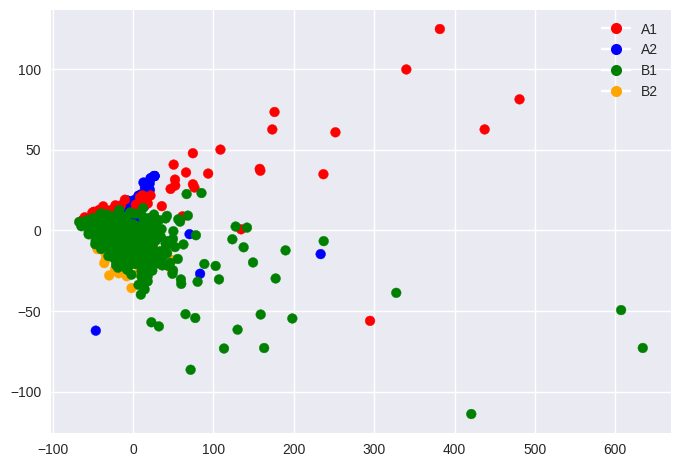

In [43]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Загрузка данных из файла students_data.csv
data = pd.read_csv('students_data.csv')
data = data[:1086]

# Извлечение процентных данных для PCA
X = data[['A1 %', 'A2 %', 'B1 %', 'B2 %']]

# Применение PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

# Добавление столбца с полученными компонентами в исходные данные
data['PC1'] = principal_components[:, 0]
data['PC2'] = principal_components[:, 1]

# Создание диаграммы рассеяния с точками, окрашенными в соответствии с уровнем
colors = {'A1': 'red', 'A2': 'blue', 'B1': 'green', 'B2': 'orange'}
plt.scatter(data['PC1'], data['PC2'], c=data['Level'].map(colors))

# Добавление легенды
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='A1', markerfacecolor='red', markersize=8),
                   plt.Line2D([0], [0], marker='o', color='w', label='A2', markerfacecolor='blue', markersize=8),
                   plt.Line2D([0], [0], marker='o', color='w', label='B1', markerfacecolor='green', markersize=8),
                   plt.Line2D([0], [0], marker='o', color='w', label='B2', markerfacecolor='orange', markersize=8)]
plt.legend(handles=legend_elements)

# Отображение диаграммы
plt.show()
